# Global Environment 

In [2]:
%matplotlib inline 
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import function
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import preprocessing
import statsmodels.api as sm

plt.rc("font", size=14)
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Load Data 

In [86]:
os.getcwd()
os.chdir('/Users/ziyisun/Documents/GitHub/Fraud')

Fraud_Data=pd.read_csv('Fraud_Data.csv')
IP=pd.read_csv('IpAddress_to_Country.csv')

# Data Preprocessing 

In [87]:
print(Fraud_Data.dtypes)
print(IP.dtypes)
print(Fraud_Data.describe())

user_id             int64
signup_time        object
purchase_time      object
purchase_value      int64
device_id          object
source             object
browser            object
sex                object
age                 int64
ip_address        float64
class               int64
dtype: object
lower_bound_ip_address    float64
upper_bound_ip_address      int64
country                    object
dtype: object
             user_id  purchase_value            age    ip_address  \
count  151112.000000   151112.000000  151112.000000  1.511120e+05   
mean   200171.040970       36.935372      33.140704  2.152145e+09   
std    115369.285024       18.322762       8.617733  1.248497e+09   
min         2.000000        9.000000      18.000000  5.209350e+04   
25%    100642.500000       22.000000      27.000000  1.085934e+09   
50%    199958.000000       35.000000      33.000000  2.154770e+09   
75%    300054.000000       49.000000      39.000000  3.243258e+09   
max    400000.000000      154.00

No Missing Data 

In [88]:
Fraud_Data[Fraud_Data.isnull().any(axis=1)]

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class


1 observation per user_id

In [89]:
len(Fraud_Data['user_id'].unique())

151112

In [90]:
Fraud_Data['signup_time']=pd.to_datetime(Fraud_Data['signup_time'],format='%Y-%m-%d %H:%M:%S')
Fraud_Data['purchase_time']=pd.to_datetime(Fraud_Data['purchase_time'],format='%Y-%m-%d %H:%M:%S')
IP['upper_bound_ip_address']=IP['upper_bound_ip_address'].astype(float)

Map IP address to country

In [91]:
IP.sort_values(by='lower_bound_ip_address',ascending=1,inplace=True)

t1=pd.datetime.now()
Fraud_Data['ip_country']=Fraud_Data['ip_address'].apply(lambda x:function.lookup(x,IP,
          "lower_bound_ip_address","upper_bound_ip_address","country"))
t2=pd.datetime.now()
print((t2-t1).seconds)

# 21966 observations have "IP Address Not Found"
Fraud_Data[["user_id","ip_country"]].groupby("ip_country").count().sort_values(by="user_id")
Fraud_Data.groupby(["ip_country","class"])['user_id'].count().unstack()
Fraud_Data.groupby('ip_country')['class'].mean().sort_values()

802


ip_country
Zimbabwe                            0.000000
Macau                               0.000000
Liechtenstein                       0.000000
Lesotho                             0.000000
Lao People's Democratic Republic    0.000000
Kyrgyzstan                          0.000000
Zambia                              0.000000
Jordan                              0.000000
Jamaica                             0.000000
Tanzania United Republic of         0.000000
Madagascar                          0.000000
Iraq                                0.000000
Guam                                0.000000
Guadeloupe                          0.000000
Gibraltar                           0.000000
Ghana                               0.000000
Gambia                              0.000000
Gabon                               0.000000
Fiji                                0.000000
Faroe Islands                       0.000000
Ethiopia                            0.000000
Haiti                               0.000000

In [92]:
Fraud_Data['ip_US']=Fraud_Data['ip_country'].apply(lambda x: 1 if x=="United States" else 0)

In [93]:
Fraud_Data['ip_not_found']=Fraud_Data['ip_country'].apply(lambda x: 1 if x=="IP Address Not Found" else 0)

In [94]:
Fraud_Data['signup_to_purchase']=Fraud_Data['purchase_time']-Fraud_Data['signup_time']
Fraud_Data['signup_to_purchase']=Fraud_Data['signup_to_purchase'].apply(lambda x:x.days*12+x.seconds//3600)

Fraud_Data[['signup_hour','purchase_hour']]=Fraud_Data[['signup_time','purchase_time']].applymap(lambda x:x.hour)
Fraud_Data[['signup_day','purchase_day']]=Fraud_Data[['signup_time','purchase_time']].applymap(lambda x:x.day)
Fraud_Data[['signup_month','purchase_month']]=Fraud_Data[['signup_time','purchase_time']].applymap(lambda x:x.month)

In [95]:
Fraud_Data=pd.merge(Fraud_Data,
                    pd.DataFrame({'Sharing_device_with':Fraud_Data.groupby('device_id')['user_id'].count()-1}),
                    left_on='device_id',right_index=True)

In [104]:
Fraud_Data=pd.merge(Fraud_Data,
                    pd.DataFrame({'Sharing_ip_with':Fraud_Data.groupby('ip_address')['user_id'].count()-1}),
                    left_on='ip_address',right_index=True)

# Explorative Analysis 

Fraud Fraction is around 9.36%

In [105]:
Fraud_Data["class"].sum()/Fraud_Data.shape[0]

0.09364577267192546

Sign up observations from 2015-01-01 00:00:42 to 2015-08-18 04:40:29

Purchase observations from 2015-01-01 00:00:44 to 2015-12-16 02:56:05

In [106]:
Fraud_Data[['signup_time','purchase_time']].min(axis=0)
Fraud_Data[['signup_time','purchase_time']].max(axis=0)

signup_time     2015-08-18 04:40:29
purchase_time   2015-12-16 02:56:05
dtype: datetime64[ns]

## Summary Statistics

In [107]:
Fraud_Data.columns

Index(['user_id', 'signup_time', 'purchase_time', 'purchase_value',
       'device_id', 'source', 'browser', 'sex', 'age', 'ip_address', 'class',
       'ip_country', 'ip_US', 'ip_not_found', 'signup_to_purchase',
       'signup_hour', 'purchase_hour', 'signup_day', 'purchase_day',
       'signup_month', 'purchase_month', 'Sharing_device_with',
       'Sharing_ip_with'],
      dtype='object')

In [109]:
tmp=Fraud_Data.loc[:,['class','purchase_value','source','browser','sex','age','signup_to_purchase',
                     'signup_hour','purchase_hour','signup_day','purchase_day','signup_month','purchase_month',
                      'ip_US','ip_not_found','Sharing_device_with','Sharing_ip_with']]

tmp.dtypes

class                   int64
purchase_value          int64
source                 object
browser                object
sex                    object
age                     int64
signup_to_purchase      int64
signup_hour             int64
purchase_hour           int64
signup_day              int64
purchase_day            int64
signup_month            int64
purchase_month          int64
ip_US                   int64
ip_not_found            int64
Sharing_device_with     int64
Sharing_ip_with         int64
dtype: object

No direct results from pair plot

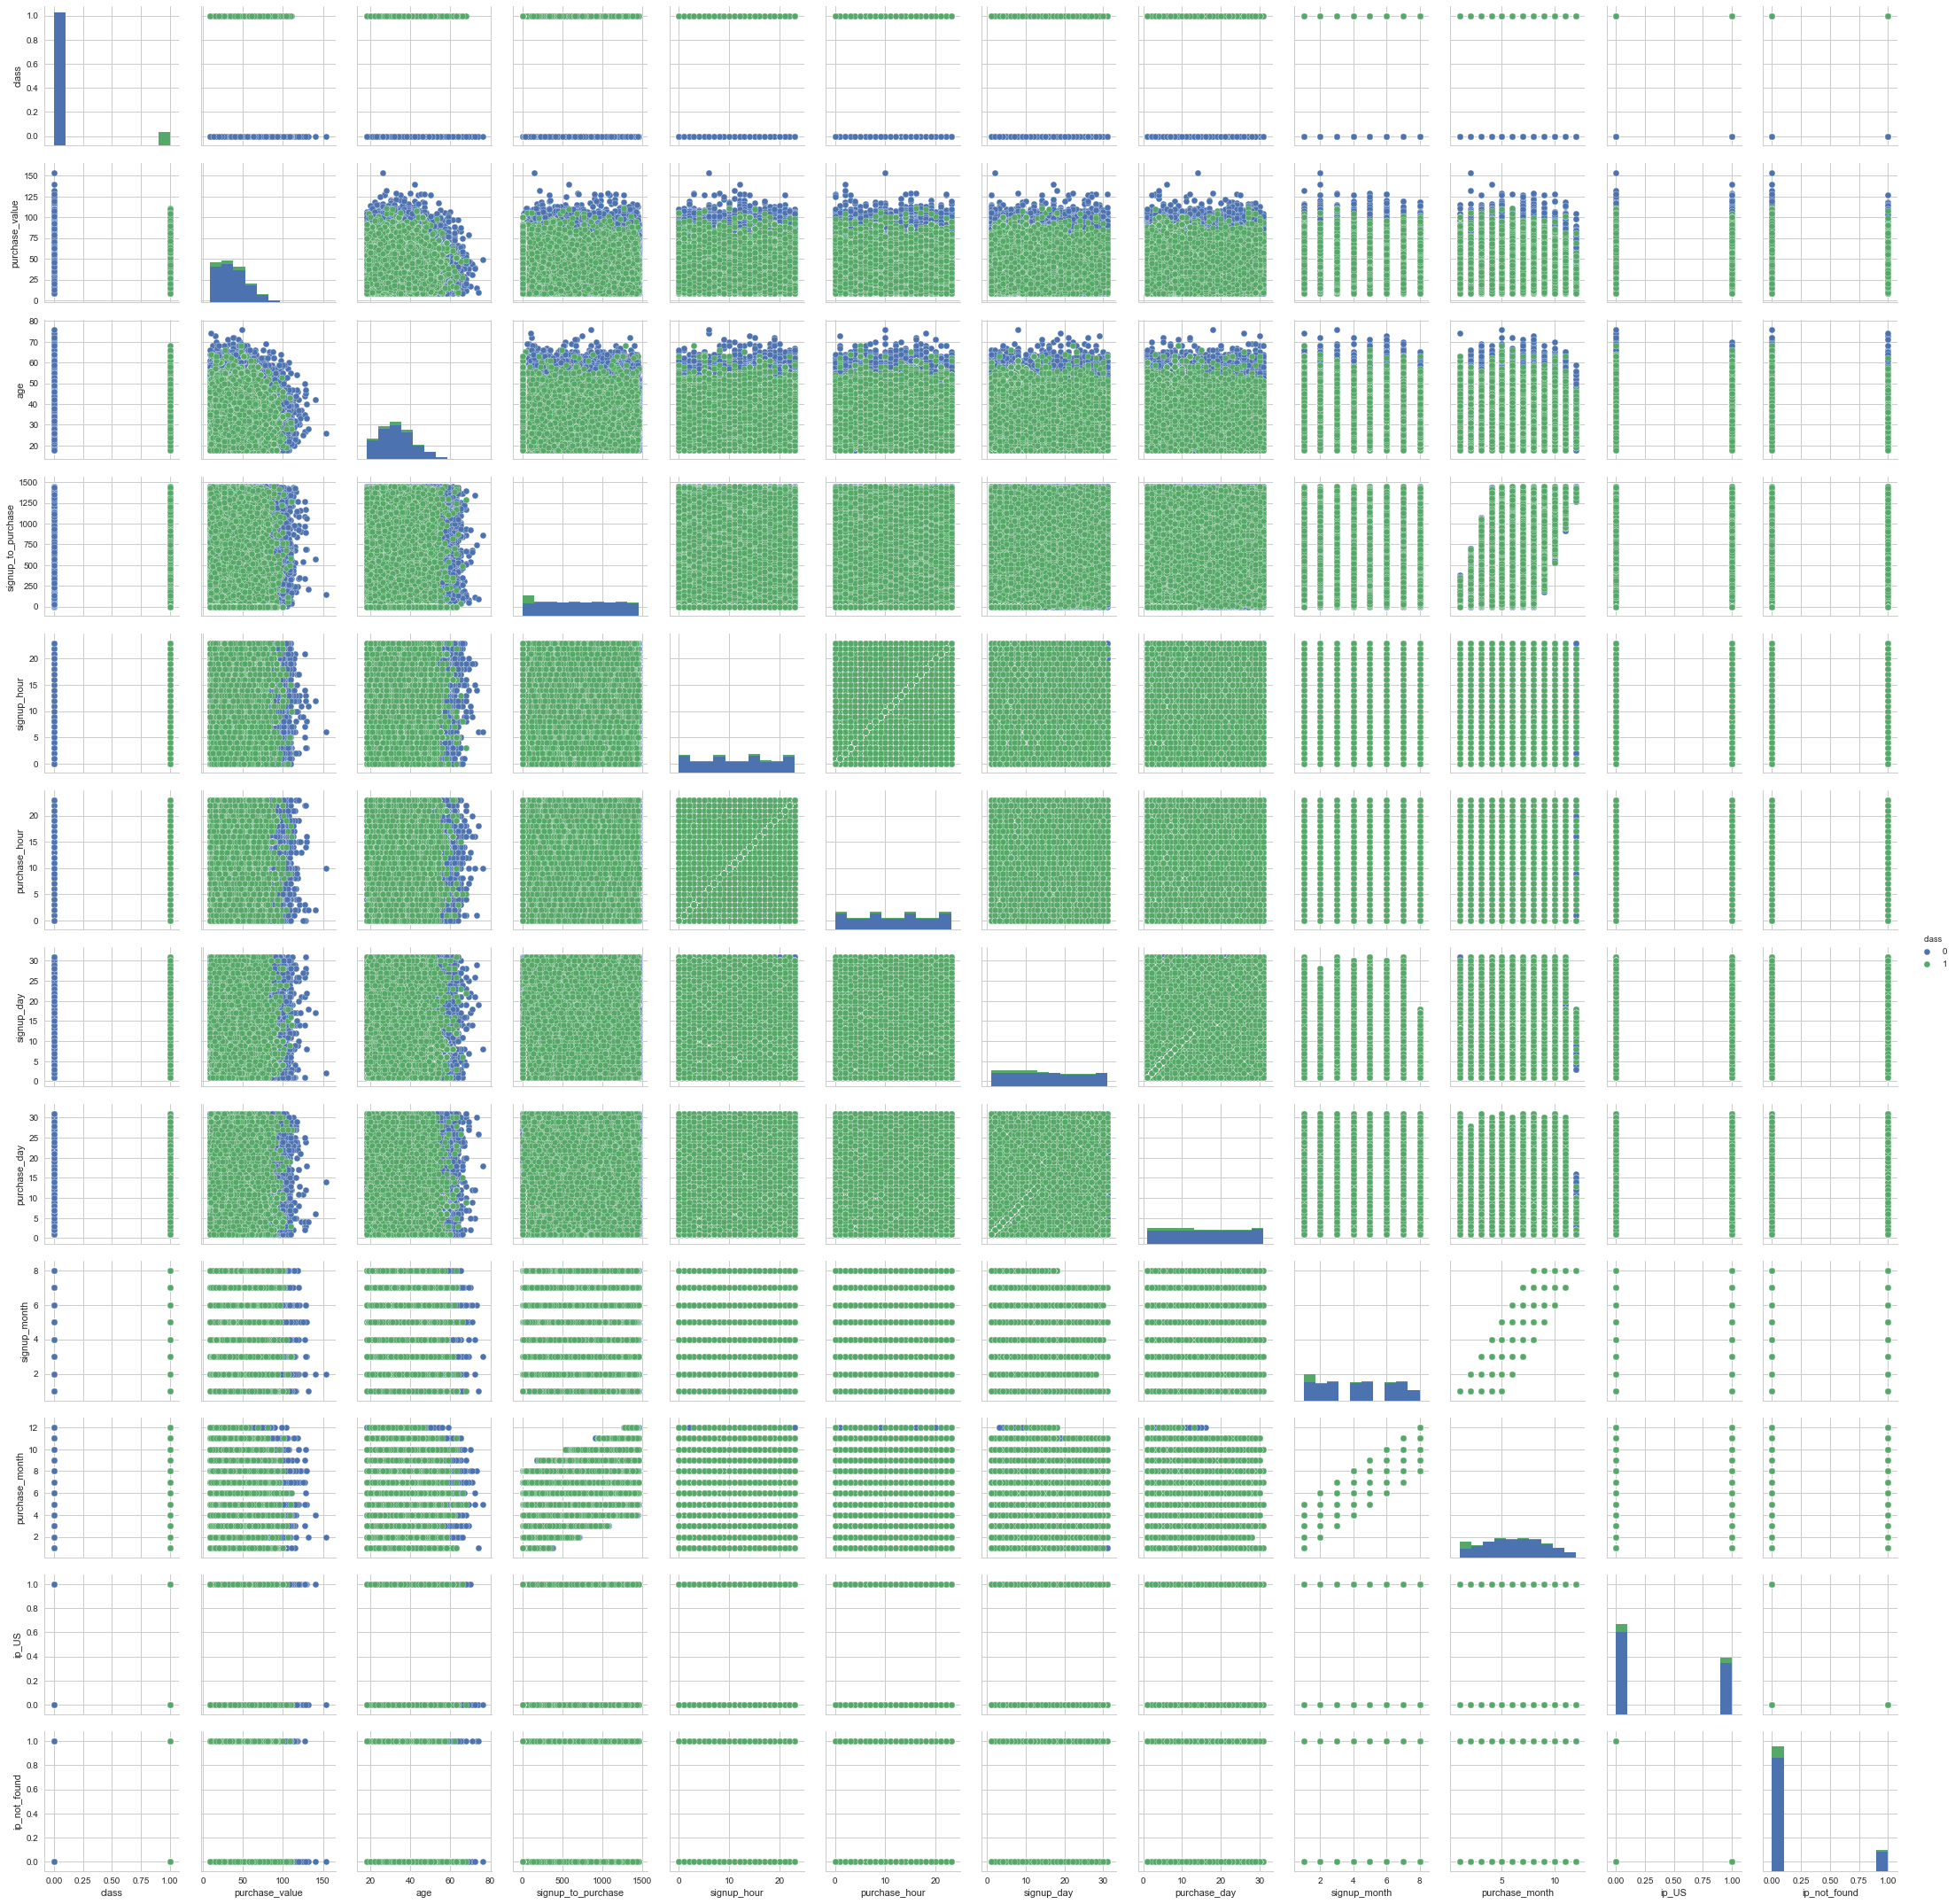

In [39]:
sns.pairplot(tmp, hue="class")

1. Purchase value is smaller for fraud;
2. Signup_to_purchase time is smaller for fraud;
3. Signup_day/Purchase_day concentrates in month beginning for fraud;
4. Signup_month/Purchase_month conecentrate in year beginning for fraud;
5. Fraud are more often associated with sharing use of device/ip;

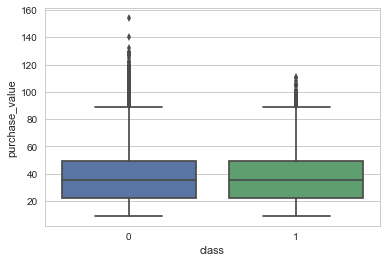

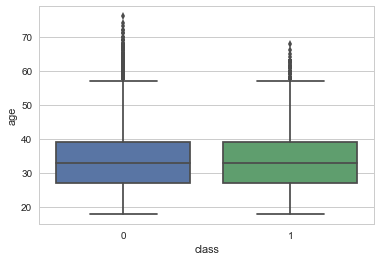

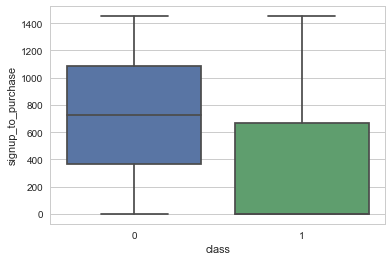

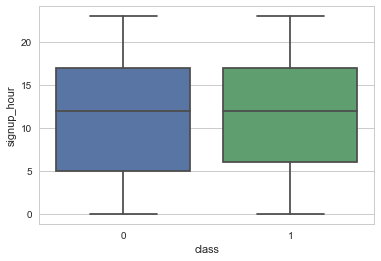

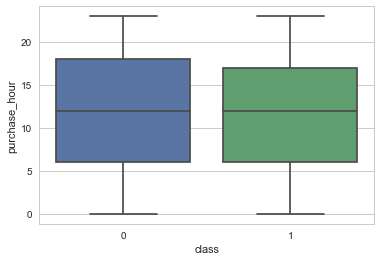

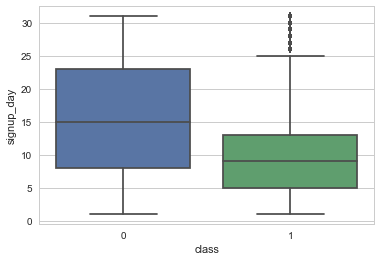

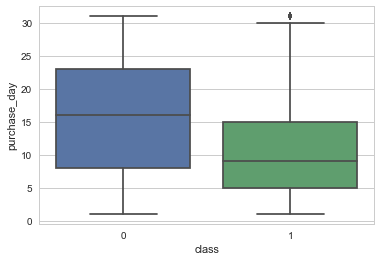

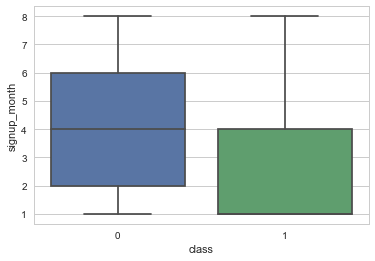

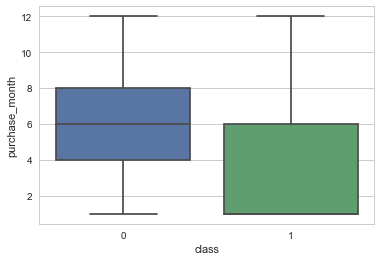

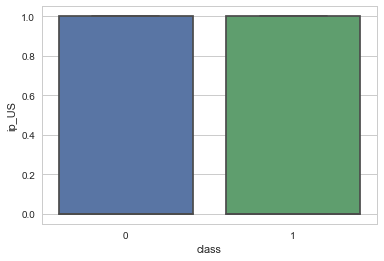

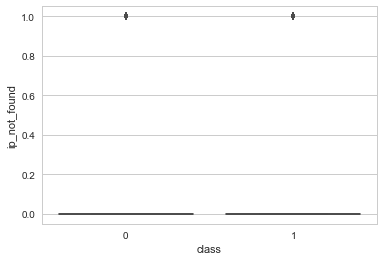

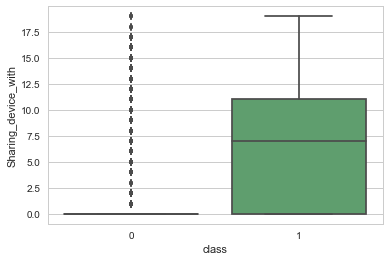

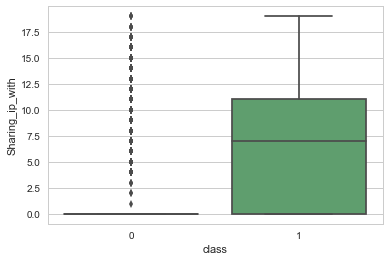

In [110]:
for var in tmp.drop('class',axis=1).columns:
    if tmp[var].dtype!='O':
        sns.boxplot(x="class", y=var, data=tmp)
        plt.show()

The difference is not that obvious for source, browser, sex

In [111]:
print(tmp.groupby('source')['class'].mean())
print(tmp.groupby('browser')['class'].mean())
print(tmp.groupby('sex')['class'].mean())

source
Ads       0.092066
Direct    0.105370
SEO       0.089285
Name: class, dtype: float64
browser
Chrome     0.098792
FireFox    0.095165
IE         0.086775
Opera      0.089227
Safari     0.090201
Name: class, dtype: float64
sex
F    0.091007
M    0.095523
Name: class, dtype: float64


Countries as Sri Lanka and Luxembourg have higher fraud rate

## Univariate Logistic Regression 

In [132]:
X=tmp.drop(['class'],axis=1)
X=pd.merge(pd.get_dummies(X[["sex","source","browser"]],prefix=["sex","source","browser"]),X,
           left_index=True,right_index=True)

X=X.loc[:,["source_Ads","source_Direct","browser_Chrome","browser_FireFox","browser_IE",
     "browser_Opera","sex_F","signup_hour","signup_day","signup_month",'purchase_hour',
       'purchase_day', 'purchase_month', 'purchase_value','age','ip_US','ip_not_found',
        'signup_to_purchase','Sharing_device_with','Sharing_ip_with']]

y=Fraud_Data.loc[:,"class"]

In [133]:
X.dtypes

source_Ads             uint8
source_Direct          uint8
browser_Chrome         uint8
browser_FireFox        uint8
browser_IE             uint8
browser_Opera          uint8
sex_F                  uint8
signup_hour            int64
signup_day             int64
signup_month           int64
purchase_hour          int64
purchase_day           int64
purchase_month         int64
purchase_value         int64
age                    int64
ip_US                  int64
ip_not_found           int64
signup_to_purchase     int64
Sharing_device_with    int64
Sharing_ip_with        int64
dtype: object

In [134]:
for var in X.columns:
    print(var)
    logit_model=sm.Logit(y,X.loc[:,var])
    result=logit_model.fit()
    print(result.summary2())
#logit_model=sm.Logit(y,X)
#result=logit_model.fit()
#print(result.summary2())

source_Ads
Optimization terminated successfully.
         Current function value: 0.540245
         Iterations 6
                          Results: Logit
Model:              Logit            Pseudo R-squared: -0.738     
Dependent Variable: class            AIC:              163276.8959
Date:               2018-11-11 14:35 BIC:              163286.8216
No. Observations:   151112           Log-Likelihood:   -81637.    
Df Model:           0                LL-Null:          -46980.    
Df Residuals:       151111           LLR p-value:      nan        
Converged:          1.0000           Scale:            1.0000     
No. Iterations:     6.0000                                        
-------------------------------------------------------------------
              Coef.   Std.Err.      z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
source_Ads   -2.2887    0.0141  -161.9212  0.0000  -2.3164  -2.2610

source_Direct
Optimization terminated

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.060     
Dependent Variable: class            AIC:              88314.5631
Date:               2018-11-11 14:35 BIC:              88324.4889
No. Observations:   151112           Log-Likelihood:   -44156.   
Df Model:           0                LL-Null:          -46980.   
Df Residuals:       151111           LLR p-value:      nan       
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     7.0000                                       
-----------------------------------------------------------------
                 Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
signup_month    -0.6623   0.0032 -205.2362 0.0000 -0.6686 -0.6559

purchase_hour
Optimization terminated successfully.
         Current function value: 0.395094
         Iterations 6
                          Results: Logit
Model:    

                           Results: Logit
Model:               Logit             Pseudo R-squared:  0.055     
Dependent Variable:  class             AIC:               88782.8580
Date:                2018-11-11 14:35  BIC:               88792.7838
No. Observations:    151112            Log-Likelihood:    -44390.   
Df Model:            0                 LL-Null:           -46980.   
Df Residuals:        151111            LLR p-value:       nan       
Converged:           1.0000            Scale:             1.0000    
No. Iterations:      7.0000                                         
--------------------------------------------------------------------
                    Coef.  Std.Err.     z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------
signup_to_purchase -0.0041   0.0000 -192.2214 0.0000 -0.0041 -0.0040

Sharing_device_with
Optimization terminated successfully.
         Current function value: 0.675981
         Iterations 6
       

# Binary Classification

## Logistic Regression

Prepare Data 

In [66]:
X=Fraud_Data.loc[:,["signup_hour","signup_day","signup_month",
                    "purchase_hour","purchase_day","purchase_month",
                    "purchase_value","source","browser","sex","age",
                    "ip_US","signup_to_purchase"]]
X=pd.merge(pd.get_dummies(X[["sex","source","browser"]],prefix=["sex","source","browser"]),X,
           left_index=True,right_index=True)

X=X.loc[:,["source_Ads","source_Direct","browser_Chrome","browser_FireFox","browser_IE",
     "browser_Opera","sex_F","signup_hour","signup_day","signup_month",'purchase_hour',
       'purchase_day', 'purchase_month', 'purchase_value','age','ip_US','signup_to_purchase']]

y=Fraud_Data.loc[:,"class"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)


Build Model

In [28]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
predictions = logreg.predict(X_test)
print(logreg.score(X_test, y_test))
print(logreg.coef_)
print(logreg.intercept_)

0.9341774385670799
[[-0.00788293  0.17051602  0.11393206  0.0746191  -0.00694739  0.11109829
  -0.03953331  0.00258657 -0.04206744 -0.05615767  0.00141109 -0.0525325
  -0.24680668  0.0010056   0.00124553  0.03199471 -0.00113202]]
[0.7884629]


## Random Forest 

In [141]:
from sklearn.ensemble import RandomForestClassifier

Split Data

In [142]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

Fit Model

In [143]:
rf=RandomForestClassifier(n_estimators=5,random_state=1)

In [144]:
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=5, n_jobs=1,
            oob_score=False, random_state=1, verbose=0, warm_start=False)

Analyze Model

In [190]:
feature_importance=pd.DataFrame({'feature':X.columns,
                                 'importance':rf.feature_importances_}).sort_values('importance',ascending=False)

print(feature_importance)

                feature  importance
17   signup_to_purchase    0.321358
18  Sharing_device_with    0.169698
12       purchase_month    0.078756
8            signup_day    0.073169
11         purchase_day    0.061884
13       purchase_value    0.054093
14                  age    0.048683
9          signup_month    0.048175
7           signup_hour    0.044039
10        purchase_hour    0.041285
6                 sex_F    0.009223
15                ip_US    0.008822
16         ip_not_found    0.006854
1         source_Direct    0.006737
4            browser_IE    0.006574
2        browser_Chrome    0.006105
3       browser_FireFox    0.005643
0            source_Ads    0.005116
19      Sharing_ip_with    0.001969
5         browser_Opera    0.001817


Validate Model

In [150]:
from sklearn import metrics

In [152]:
y_pred=rf.predict(X_test)

In [153]:
print(metrics.classification_report(y_pred,y_test))

             precision    recall  f1-score   support

          0       0.99      0.96      0.97     42678
          1       0.55      0.88      0.68      2656

avg / total       0.97      0.95      0.96     45334



Text(92.68,0.5,'y_pred')

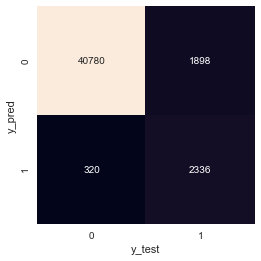

In [155]:
from sklearn.metrics import confusion_matrix 
mat = confusion_matrix(y_test,y_pred)
sns.heatmap(mat.T,square=True,annot=True,fmt='d',cbar=False)
plt.xlabel('y_test')
plt.ylabel('y_pred')

In [161]:
comp=pd.DataFrame({'label':y_test,
                  'prediction':rf.predict_proba(X_test)[:,1]})

print(comp)

        label  prediction
132496      0         0.0
21508       0         0.0
113968      0         0.0
22420       0         0.0
150556      0         0.2
129326      0         0.2
91508       0         0.0
21706       0         0.2
7808        0         0.0
89194       0         0.2
17670       1         0.0
10622       0         0.2
136387      0         0.0
99303       1         1.0
25364       0         0.0
20714       0         0.0
113050      0         0.0
120058      0         0.0
60973       0         0.0
103290      0         0.0
101278      0         0.0
76853       0         0.2
119248      0         0.0
98381       0         0.0
98657       0         0.2
56759       0         0.0
54878       0         0.0
146918      0         0.0
16346       0         0.0
88023       0         0.2
...       ...         ...
149528      0         0.0
15651       0         0.0
127504      0         0.0
30710       0         0.2
134079      0         0.0
36466       1         1.0
57344       

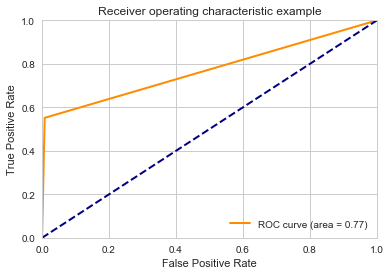

In [191]:
fpr,tpr,thresholds= metrics.roc_curve(y_test, y_pred)
roc_auc= metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

# Conclusion

## Some Facts of Fraudulent Activities

1. Signup to purchase time difference is the most important feature to dedect fraudulent activities: we would expect the time from signing up to conducting a purchase is shorter for fraudulent activities; 
2. Other powerful indicators could be: sharing the same device id or ip address with multiple users;
3. In general, fraudulent activities are more often to happen during month and year beginning; 


## Leveraging Model to Predict Fraud

1. The model has out-of-sample ROC=0.77;
2. Different false positive or false negative cost would lead to different cut-off choice